<a href="https://colab.research.google.com/github/SL-207/ViLT-Visual-Question-Answering/blob/main/T5_for_Book_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Load Dataset

In [1]:
!pip install -Uq transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-

In [2]:
from datasets import load_dataset

data = load_dataset("opus_books", "en-es")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/93470 [00:00<?, ? examples/s]

In [3]:
data

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 93470
    })
})

In [4]:
data['train'][0]

{'id': '0',
 'translation': {'en': 'Source: Project GutenbergAudiobook available here',
  'es': 'Source: Wikisource & librodot.com'}}

In [5]:
data['train'][:5]

{'id': ['0', '1', '2', '3', '4'],
 'translation': [{'en': 'Source: Project GutenbergAudiobook available here',
   'es': 'Source: Wikisource & librodot.com'},
  {'en': 'Sense and Sensibility', 'es': 'SENTIDO Y SENSIBILIDAD'},
  {'en': 'Jane Austen', 'es': 'JANE AUSTEN'},
  {'en': 'CHAPTER 1', 'es': 'CAPITULO I'},
  {'en': 'The family of Dashwood had long been settled in Sussex.',
   'es': 'La familia Dashwood llevaba largo tiempo afincada en Sussex.'}]}

### 2. Preprocess and Split data

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("t5-small")

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [7]:
source_lang = "en"
target_lang = "es"
prefix = "translate English to Spanish: " # prefix prompt for multitask LLMs

def preprocess_function(samples):
    # inputs is list of text samples since batched=True
    inputs = [prefix + book[source_lang] for book in samples["translation"]]
    targets = [book[target_lang] for book in samples["translation"]]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True)

    # Set up the tokenizer for targets (different language)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True)

    # only take input ids for tokenized targets
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_data = data.map(preprocess_function, batched=True)

Map:   0%|          | 0/93470 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [8]:
tokenized_data = tokenized_data["train"].train_test_split(test_size=0.2)

In [9]:
print(tokenized_data['train'][0])

{'id': '40682', 'translation': {'en': '"Let us understand each other, my Lord," replied d’Artagnan, "and let us make things clear beforehand in order that there may be no mistake.', 'es': "Entendámonos milord respondió D'Artagnan , y sopesemos bien los hechos por adelantado, a fin de que no haya desprecio en ello."}, 'input_ids': [13959, 1566, 12, 5093, 10, 96, 2796, 17, 178, 734, 284, 119, 6, 82, 2809, 976, 18606, 3, 26, 22, 7754, 9, 11260, 29, 6, 96, 232, 752, 178, 143, 378, 964, 23735, 16, 455, 24, 132, 164, 36, 150, 6202, 5, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [4443, 989, 2975, 2157, 32, 7, 3, 51, 967, 26, 3531, 23, 4922, 309, 31, 7754, 9, 11260, 29, 3, 6, 3, 63, 78, 855, 7, 15, 3972, 923, 10381, 3, 88, 3995, 7, 5569, 3, 15311, 288, 9, 26, 32, 6, 3, 9, 2202, 20, 238, 150, 3, 12687, 9, 1578, 75, 23, 32, 3, 35, 3, 7126, 5, 1]}


### 3. Prepare model and Fine-tune

In [28]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [11]:
model

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [12]:
# Collate function for dynamic padding
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

In [13]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    fp16=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

<ipython-input-13-a707ad45f18d>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sl207020 (sl207020-newcastle-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,3.120800,2.812503


TrainOutput(global_step=4674, training_loss=3.2459182314858457, metrics={'train_runtime': 756.8328, 'train_samples_per_second': 98.801, 'train_steps_per_second': 6.176, 'total_flos': 1959398242516992.0, 'train_loss': 3.2459182314858457, 'epoch': 1.0})

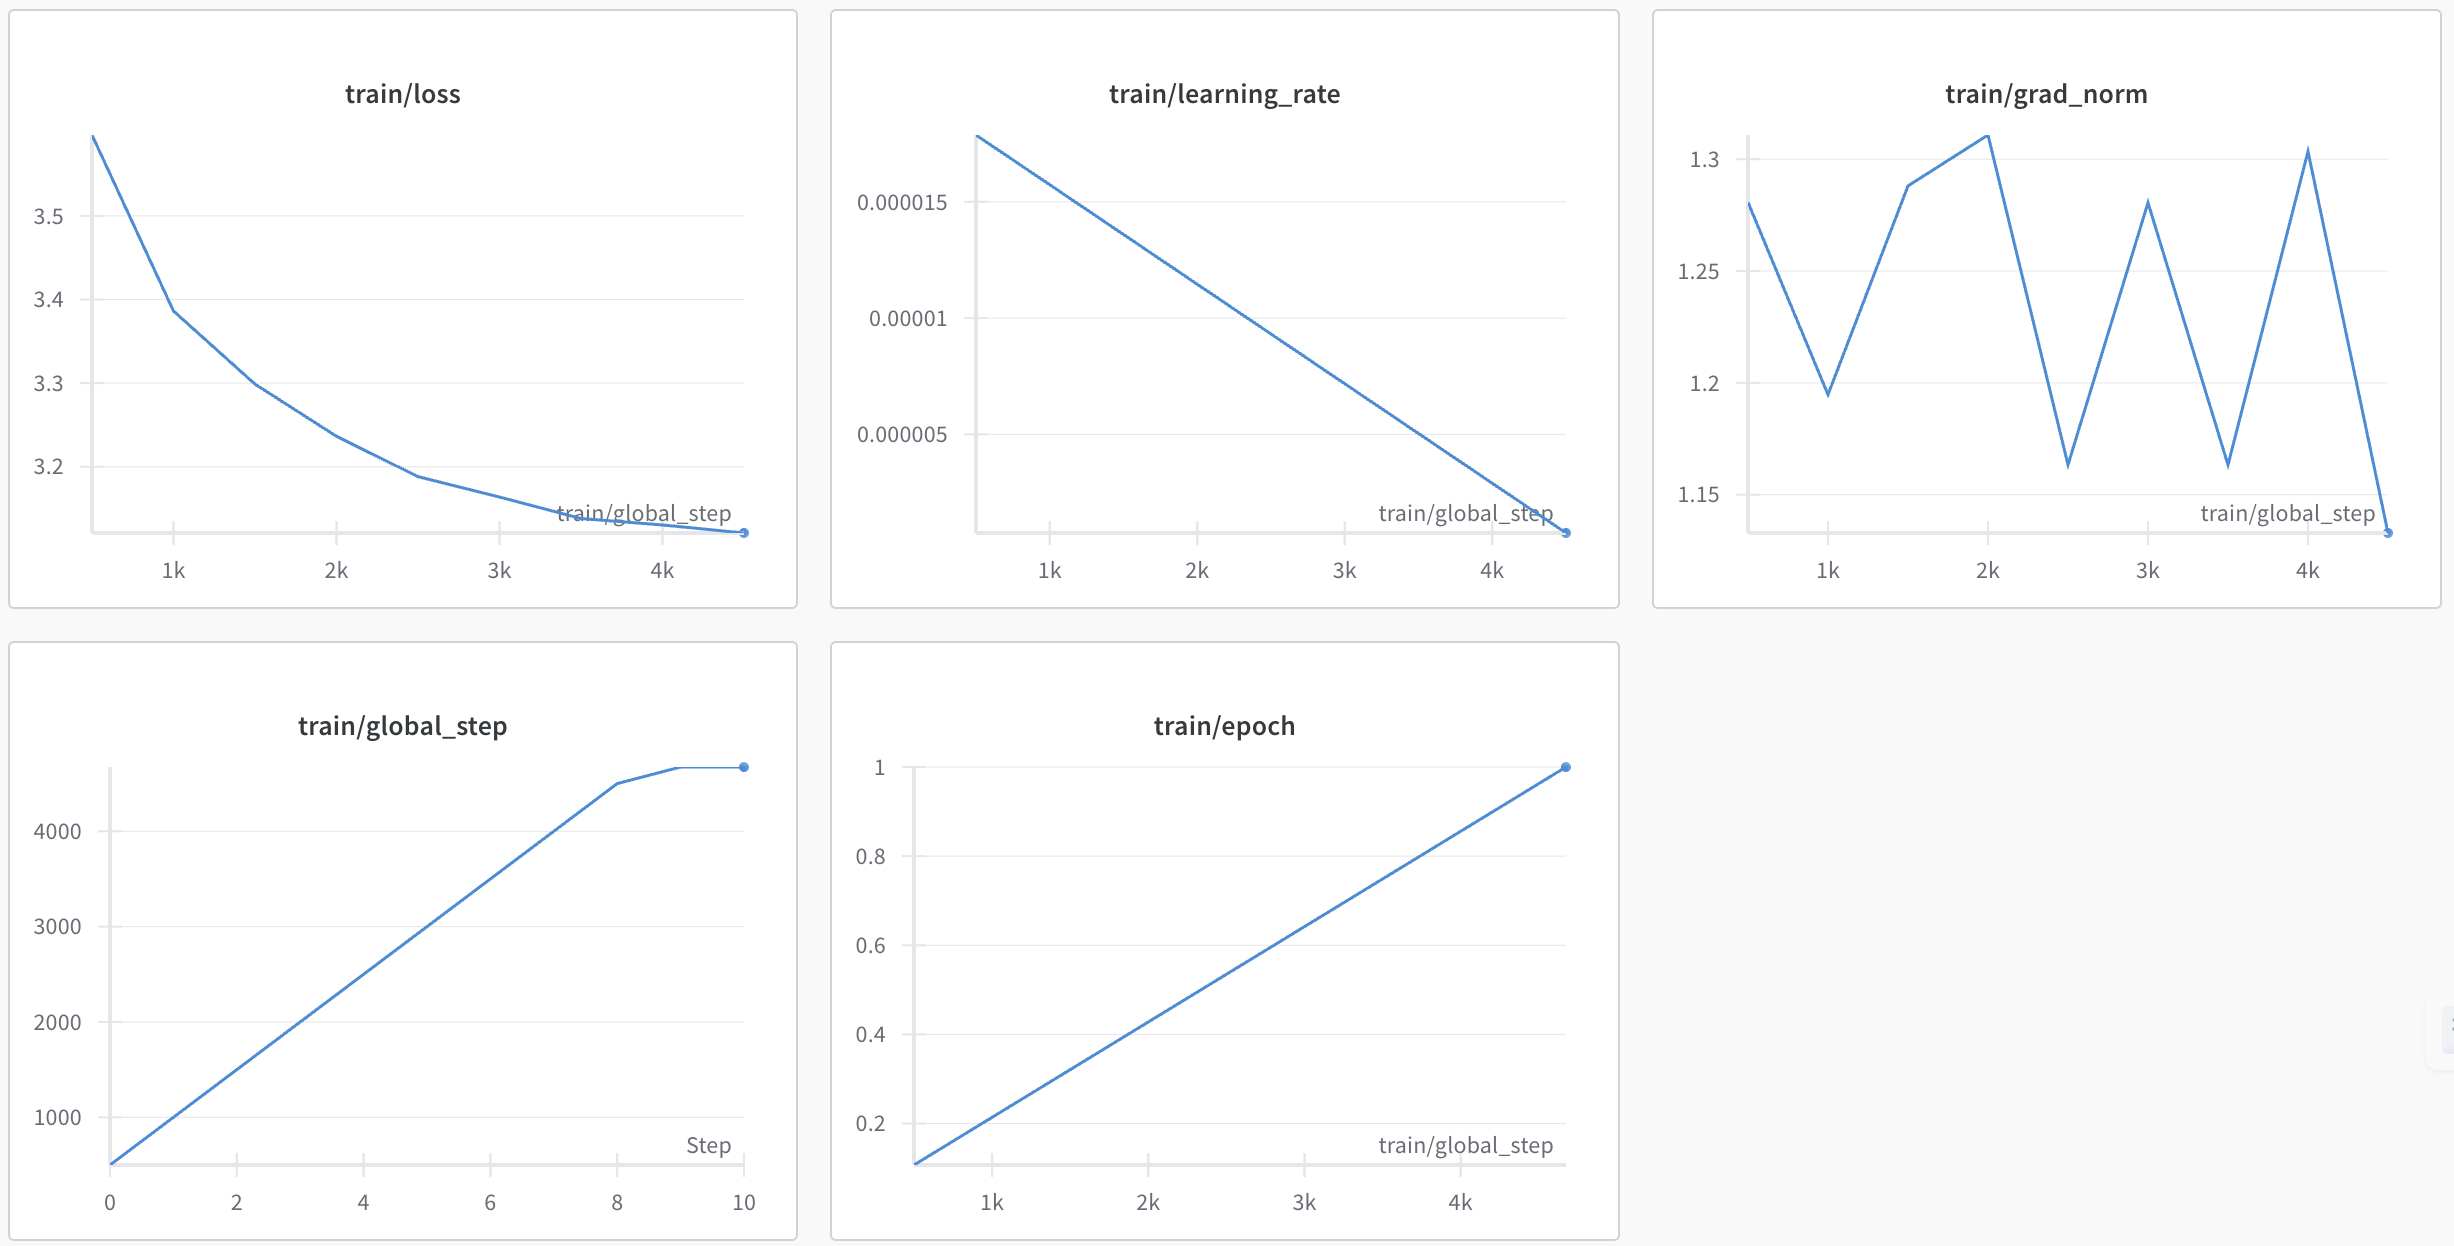

### 4. Test Inference

In [53]:
# Run inference on test sample
# Note: model still imperfect after 1 epoch
test_input_ids = torch.tensor(tokenized_data["test"][2]['input_ids']).unsqueeze(0)
outputs = model.generate(
    test_input_ids.to(device),
    max_length=150,
    top_p=0.95,
    do_sample=True,
)
out_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(tokenized_data["test"][2]["translation"][source_lang])
print(out_text)

The Session was opened by the Governor of the Province, who in his speech to the nobles told them that in choosing occupants for posts they should show no partiality, but should choose according to merit and for the welfare of the country, and that he hoped the honourable Nobility of Kashin would strictly fulfil its duty as it had done in previous elections, and would justify their sovereign's high confidence in them.
A la Session apreció en el Gouverneur de la provincia, dequ, decirsió en seguridad a los nobles, que en choisido a los occupantes nuestro pronto y se plecar, que no dependo por parte de meritos y por estos sobrestas. Aquella mejor nobilidad de Kashin a realgar losas seor durante que hablara, que la a el élhone, que igua


In [41]:
context = "Can you translate this text?"
input_text = f"translate English to Spanish: {context}"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids

outputs = model.generate(
    input_ids.to(device),
    max_length=150,
    temperature=0.9,
    top_p=0.95,            # Nucleus sampling
    do_sample=True,        # Enables sampling
)
out_question = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(out_question)

Peut-on traducer le texto y en las medios?
